## Imports

In [3]:
import glob
from skimage import io
from skimage import color
from skimage.transform import resize
from matplotlib import pyplot as plt
import cv2
import numpy as np
from sklearn.decomposition import PCA
%load_ext autoreload
%autoreload 2
import predict
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualizing preprocessing

In [4]:
fnimages = ['data/MYDATA/train/0_0.png', 
            'data/MYDATA/train/100_5.png',
            'data/MYDATA/train/121_6.png', 
            'data/MYDATA/train/200_9.png']

def visualize_pp(processed_images, original_images, num=20):
    for iprocessed, ioriginal in zip(processed_images[0:num], original_images[0:num]):
        plt.subplot(121)
        plt.title('Original')
        plt.imshow(ioriginal, cmap="Greys_r")
        plt.subplot(122)
        plt.title('Processed')
        plt.imshow(iprocessed, cmap="Greys_r")
        plt.show()

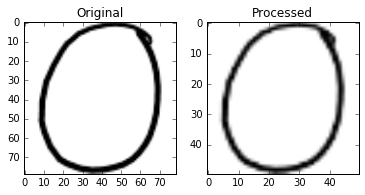

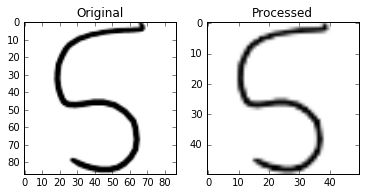

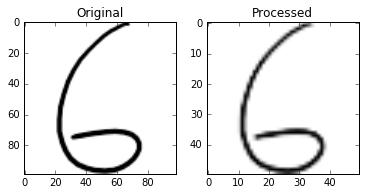

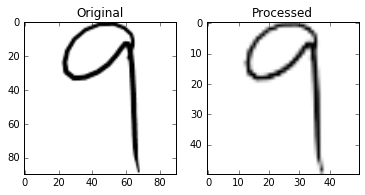

In [5]:
import predict
images_raw = []
images_proc = []
for fn in fnimages:
    ilabels, iraw = predict.file_to_raw_symbols(fn, True)
    iraw = iraw.squeeze()
    iproc = predict.preprocess_image(iraw)
    images_raw.append(iraw)
    images_proc.append(iproc)
visualize_pp(images_proc, images_raw, num=20)

## Get training data

In [ ]:
import predict
input_images, input_hogs, images_processed, images_hog, symbols, images_raw_symbols = predict.get_custom_data('data/MYDATA/train/')

In [4]:
import glob
symbol_counts = {}
for name in glob.glob('data/MYDATA/train/*.png'):
    symbol = name.split('_')[1].replace(".png","")
    if(symbol in symbol_counts):
        symbol_counts[symbol] += 1
    else:
        symbol_counts[symbol] = 1
        
for key, value in symbol_counts.items():
    print(str(key) + " : " + str(value))

u : 40
9 : 40
3 : 40
q : 40
0 : 40
i : 40
8 : 40
comma : 40
divslash : 40
a : 40
ww : 40
e : 40
d : 40
v : 40
plus : 40
rightparen : 40
6 : 40
c : 40
leftparen : 40
b : 40
4 : 40
minus : 40
1 : 40
2 : 40
nn : 40
x : 40
mm : 40
ii : 40
int : 40
7 : 40
j : 40
sum : 50
5 : 40


## Training models and stuff

In [24]:
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import copy

transforms = [
#     PCA(n_components=5),
#     PCA(n_components=10),
#     PCA(n_components=15),
#     PCA(n_components=20),
#     PCA(n_components=25),
#     PCA(n_components=30),
    PCA(n_components=35),
    PCA(n_components=40),
    PCA(n_components=50),
    PCA(n_components=60)
#     PCA(n_components=65),
#     PCA(n_components=70)
]

models = [
    MLPClassifier(alpha=.001),
    MLPClassifier(),
    MLPClassifier(hidden_layer_sizes=(100,100), alpha=.001),
    MLPClassifier(hidden_layer_sizes=(100,100))
#     SVC(),
#     SVC(kernel='linear'),
#     KNeighborsClassifier(n_neighbors=5),
#     KNeighborsClassifier(n_neighbors=10),
#     KNeighborsClassifier(n_neighbors=15),
#     SVC(degree=5),
#     MLPClassifier(hidden_layer_sizes=(100,100,10), alpha=.001),
#     MLPClassifier(hidden_layer_sizes=(100,100,10), alpha=.0001),
#     LogisticRegression()
]

def find_model(X, y, models, transforms):
    models = copy.deepcopy(models)
    transforms = copy.deepcopy(transforms)
    
    for ts in transforms:
        ts.fit(X)

    bscore = 0
    for model in models:
        for ts in transforms:
            Xts = ts.transform(X)
            score = np.mean(cross_val_score(model, Xts, y, cv=3))
            if(score > bscore):
                bmodel = model
                bts = ts
                bscore = score
    
    return bmodel, bts, bscore

bmodel, bts, bscore = find_model(input_images, symbols, models, transforms)
hogbmodel, hogbts, hogbscore = find_model(input_hogs, symbols, models, transforms)

print(bmodel)
print(bts)
print(bscore)
print()
print(hogbmodel)
print(hogbts)
print(hogbscore)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
PCA(copy=True, iterated_power='auto', n_components=35, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
0.881305521009

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_sta

In [25]:
from sklearn.externals import joblib

Xts = bts.transform(input_images)
bmodel.fit(Xts, symbols)
print(bmodel.score(Xts, symbols))

Xts = hogbts.transform(input_hogs)
hogbmodel.fit(Xts, symbols)
print(hogbmodel.score(Xts, symbols))

joblib.dump(bmodel, 'models/Model' + '.p')
joblib.dump(bts, 'models/Ft' + '.p')
joblib.dump(hogbmodel, 'models/ModelHog' + '.p')
joblib.dump(hogbts, 'models/FtHog' + '.p')

1.0
1.0


['models/FtHog.p']

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c',
       'comma', 'd', 'divslash', 'e', 'i', 'ii', 'int', 'j', 'leftparen',
       'minus', 'mm', 'nn', 'plus', 'q', 'rightparen', 'sum', 'u', 'v',
       'ww', 'x'], 
      dtype='<U10')

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

estimators = [('reduce_dim', PCA()), ('clf', MLPClassifier())]
pipe = Pipeline(estimators)

params = dict(reduce_dim=[PCA()],
            clf=[MLPClassifier()],
            reduce_dim__n_components=[30, 40, 50, 60],
            clf__hidden_layer_sizes=[(100,),(100,100),(20, 100)])
grid_search = GridSearchCV(pipe, param_grid=params)
grid_search.fit(input_images, symbols)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidde...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__hidden_layer_sizes': [(100,), (100, 100), (20, 100)], 'reduce_dim__n_components': [30, 40, 50, 60], 'reduce_dim': [PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)], 'clf': [MLPClassifier(activation='relu', alpha=...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
  

In [35]:
sorted(grid_search.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_clf',
 'param_clf__hidden_layer_sizes',
 'param_reduce_dim',
 'param_reduce_dim__n_components',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']